In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import sys; sys.path.append("../src/")
from data_utils import TweetDataset
from models import SmoothMaskedTextClassifier
from transformers import AutoModelForSequenceClassification
from stability import soft_stability_rate_text

torch.manual_seed(1234)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
run_stuff = True
overwrite_cache = True

In [3]:
# Labels: anger (0), joy (1), optimism (2), sadness (3)
dataset = TweetDataset(
    "/shared_data0/helenjin/tweeteval/datasets/emotion/val_text.txt",
    "/shared_data0/helenjin/tweeteval/datasets/emotion/val_labels.txt",
    task = "emotion"
)
print(len(dataset))

374


In [4]:
lambdas = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.25, 0.2, 0.1]
print(lambdas)

[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.25, 0.2, 0.1]


In [5]:
accs = []

In [6]:
if run_stuff:
    for lambda_ in lambdas:
        smooth_roberta = SmoothMaskedTextClassifier(
            AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion"),
            num_samples = 64,
            lambda_ = lambda_
        ).eval().to(device)

        hits, num_dones = 0, 0
        pbar = tqdm(dataset)
        with torch.no_grad():
            for inputs, label in pbar:
                out = smooth_roberta(
                    input_ids = inputs["input_ids"].to(device),
                    attention_mask = inputs["attention_mask"].to(device)
                )
                hits += (out.argmax(dim=-1) == label).item()
                num_dones += 1
                pbar.set_description(f"lambda {lambda_:.3f}, acc {(hits/num_dones):.3f}")
            accs.append(hits/num_dones)

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

In [7]:
if overwrite_cache and len(accs) > 0:
    torch.save({"lambdas":lambdas, "accs":accs}, "_cache/roberta_accuracy_vs_lambda.pt")

In [8]:
# accs = torch.load("_cache/roberta_accuracy_vs_lambda.pt")["accs"]

<Figure size 640x480 with 0 Axes>

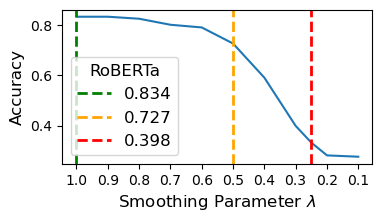

In [43]:
fs = 12
plt.clf()
fig, ax = plt.subplots(figsize=(4,2))
ax.plot(lambdas, accs)
plt.gca().invert_xaxis()

ax.set_xticks([1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])
ax.set_ylabel("Accuracy", fontsize=fs)
ax.set_xlabel("Smoothing Parameter $\lambda$", fontsize=fs)

ax.tick_params(axis="both", labelsize=fs-2)
ax.axvline(x=1.0, color="green", linestyle="--", linewidth=2, label=f"{accs[0]:.3f}")
ax.axvline(x=0.5, color="orange", linestyle="--", linewidth=2, label=f"{accs[5]:.3f}")
ax.axvline(x=0.25, color="red", linestyle="--", linewidth=2, label=f"{accs[7]:.3f}")

ax.legend(title="RoBERTa", loc="lower left", title_fontsize=fs, fontsize=fs)
plt.savefig("../figures/roberta_accuracy_vs_lambda.pdf", bbox_inches="tight")